In [1]:
#@title Δεδομένα στο Drive.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#@title Βιβλιοθήκες
!pip install pip numpy pandas
!pip install openml
!pip install imbalanced-learn
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
import pickle
import warnings
warnings.filterwarnings('ignore')
import openml as oml
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC 
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [11]:
#@title Dataset

# Dictionaries ια σύγκριση αποτελεσμάτων
accuracy_best_ac = {}
f1score_best_ac = {}
train_time_ac = {}
test_time_ac = {}
param_ac = {}

base_path = "/content/gdrive/My Drive/art_recognition/Datasets/Dataset 100/"
train = "painting_features_train_small.pkl"
test = "painting_features_test_small.pkl"
val = "painting_features_val_small.pkl"
with open(base_path + train,"rb") as f:
  tra = pickle.load(f)
with open(base_path + test,"rb") as f:
  tes = pickle.load(f)
with open(base_path + val,"rb") as f:
  vali = pickle.load(f)

trai, trai_labels = zip(*tra)
val, val_labels = zip(*vali)
train = trai + val
train_labels = trai_labels + val_labels
test, test_labels = zip(*tes)

### Ταξινόμηση με Machine Learning

In [ ]:
#@title KNeirest Neighbors (kNN)

# Aρχικοποιούμε τον εκτιμητή (ταξινομητής) και τους μετασχηματιστές 
# χωρίς υπερ-παραμέτρους
knn = KNeighborsClassifier(n_jobs=-1) 
pca = PCA()

# Ορίζουμε τις πιθανές τιμές των υπερπαραμέτρων
parameter_space = {
    'pca__n_components': [100, 500, 800, None],
    'kNN__n_neighbors': [3, 5, 7, 9, 11],
    'kNN__leaf_size': (20,40,1),
    'kNN__weights': ('uniform', 'distance'),
    'kNN__metric': ('minkowski', 'chebyshev')
}


# Ορισμός Pipeline και εύρεση βέλτιστων υπερπαραμέτρων
pipe = Pipeline(steps=[('pca', pca), ('kNN', knn)], memory = 'tmp')
estimator = GridSearchCV(pipe, parameter_space, cv=10,
                         scoring='accuracy', n_jobs=-1)
estimator.fit(train, train_labels)

kneab = estimator.best_params_['kNN__n_neighbors']
leaf = estimator.best_params_['kNN__leaf_size']
weig = estimator.best_params_['kNN__weights']
met = estimator.best_params_['kNN__metric']
n = estimator.best_params_['pca__n_components']

# Εκπαίδευση μοντέλου με τις βέλτιστες υπερπαραμέτρους
knn = KNeighborsClassifier(n_neighbors=kneab,leaf_size=leaf,
                           weights=weig,metric=met, n_jobs=-1) 
pca = PCA(n_components=n)
trainPCA = pca.fit_transform(train)
testPCA = pca.transform(test)

# Χρονομέτρηση training
start = time.time()
knn.fit(trainPCA, train_labels)
end = time.time()
train_time = end - start
# Χρονομέτρηση testing
start = time.time()
preds = knn.predict(testPCA)
end = time.time()
test_time = end - start

accuracy = accuracy_score(test_labels, preds)
accuracy_best_ac['k neirest neighbors'] = accuracy
f1score_best_ac['k neirest neighbors'] = f1_score(test_labels, preds, average='macro')
train_time_ac['k neirest neighbors'] = train_time
test_time_ac['k neirest neighbors'] = test_time
param_ac['k neirest neighbors'] = estimator.best_params_

In [ ]:
#@title Logistic Regression (LR)

# Aρχικοποιούμε τον εκτιμητή (ταξινομητής) και τους μετασχηματιστές 
# χωρίς υπερ-παραμέτρους
logisticRegr = LogisticRegression()
pca = PCA()

# Ορίζουμε τις πιθανές τιμές των υπερπαραμέτρων
n_components = [10, 20, 30, 40, None]
penalty = ['l1','l2',None]
C = [0.1,1,10,100,1000,10000]

# Ορισμός Pipeline και εύρεση βέλτιστων υπερπαραμέτρων
pipe = Pipeline(steps=[('pca', pca), ('LR', logisticRegr)], memory = 'tmp')
estimator = GridSearchCV(pipe, dict(pca__n_components=n_components,LR__penalty=penalty, LR__C=C)
, cv=10, scoring='accuracy', n_jobs=-1)
estimator.fit(train, train_labels)
pen = estimator.best_params_['LR__penalty']
c = estimator.best_params_['LR__C']
n = estimator.best_params_['pca__n_components']

# Εκπαίδευση μοντέλου με τις βέλτιστες υπερπαραμέτρους
logisticRegr = LogisticRegression(penalty=pen,C=c)
pca = PCA(n_components=n)
trainPCA = pca.fit_transform(train)
testPCA = pca.transform(test)

# Χρονομέτρηση training
start = time.time()
logisticRegr.fit(trainPCA, train_labels)
end = time.time()
train_time = end - start

# Χρονομέτρηση testing
start = time.time()
preds = logisticRegr.predict(testPCA)
end = time.time()
test_time = end - start

accuracy = accuracy_score(test_labels, preds)
accuracy_best_ac['logistic regression'] = accuracy
f1score_best_ac['logistic regression'] = f1_score(test_labels, preds, average='macro')
train_time_ac['logistic regression'] = train_time
test_time_ac['logistic regression'] = test_time
param_ac['logistic regression']=estimator.best_params_

In [ ]:
#@title Multi-Layer Perceptron (MLP)

# Aρχικοποιούμε τον εκτιμητή (ταξινομητής) και τους μετασχηματιστές 
# χωρίς υπερ-παραμέτρους
mlp = MLPClassifier()
pca = PCA()

# Ορίζουμε τις πιθανές τιμές των υπερπαραμέτρων

parameter_space = {
    'pca__n_components': [10, 20, 30, 40, None],
    'MLP__hidden_layer_sizes': [(10,),(52,)],
    'MLP__alpha': [0.0001, 0.05],
    'MLP__learning_rate_init': np.arange(0.002,0.003,0.0001),
    'MLP__learning_rate': ['constant','adaptive']
}


# Ορισμός Pipeline και εύρεση βέλτιστων υπερπαραμέτρων
pipe = Pipeline(steps=[('pca', pca), ('MLP', mlp)],
                memory = 'tmp')
estimator = GridSearchCV(pipe, parameter_space, cv=10, 
                         scoring='accuracy', n_jobs=-1)
estimator.fit(train, train_labels)

n = estimator.best_params_['pca__n_components']
hid = estimator.best_params_['MLP__hidden_layer_sizes']
al = estimator.best_params_['MLP__alpha']
lr = estimator.best_params_['MLP__learning_rate']
lear = estimator.best_params_['MLP__learning_rate_init']


# Εκπαίδευση μοντέλου με τις βέλτιστες υπερπαραμέτρους
mlp = MLPClassifier(hidden_layer_sizes = hid, learning_rate_init =lear,
          alpha = al, learning_rate=lr)
pca = PCA(n_components=n)
trainPCA = pca.fit_transform(train)
testPCA = pca.transform(test)

# Χρονομέτρηση training
start = time.time()
mlp.fit(trainPCA, train_labels)
end = time.time()
train_time = end - start

# Χρονομέτρηση testing
start = time.time()
preds = mlp.predict(testPCA)
end = time.time()
test_time = end - start

accuracy = accuracy_score(test_labels, preds)
accuracy_best_ac['multi-layer perceptron'] = accuracy
f1score_best_ac['multi-layer perceptron'] = f1_score(test_labels, preds, average='macro')
train_time_ac['multi-layer perceptron'] = train_time
test_time_ac['multi-layer perceptron'] = test_time
param_ac['multi-layer perceptron']=estimator.best_params_

In [ ]:
#@title Support Vector Machine (SVM) 

svc = SVC()

# Ορίζουμε τις πιθανές τιμές των υπερπαραμέτρων

param_grid = {
              'SVM__C': [1, 10, 100, 1000], 
              'SVM__gamma': [10,1,0.1,0.01]
              }
# Ορισμός Pipeline και εύρεση βέλτιστων υπερπαραμέτρων
pipe = Pipeline(steps=[('SVM', svc)])
estimator = GridSearchCV(pipe, param_grid, cv=10, 
                         scoring='accuracy', n_jobs=-1)
estimator.fit(train, train_labels)


c = estimator.best_params_['SVM__C']
gam = estimator.best_params_['SVM__gamma']

# Εκπαίδευση μοντέλου με τις βέλτιστες υπερπαραμέτρους
svc = SVC(C=c,gamma=gam)

# Χρονομέτρηση training
start = time.time()
svc.fit(train, train_labels)
end = time.time()
train_time = end - start

# Χρονομέτρηση testing
start = time.time()
preds = svc.predict(test)
end = time.time()
test_time = end - start

accuracy = accuracy_score(test_labels, preds)
accuracy_best_ac['support vector machine'] = accuracy
f1score_best_ac['support vector machine'] = f1_score(test_labels, preds, average='macro')
train_time_ac['support vector machine'] = train_time
test_time_ac['support vector machine'] = test_time
param_ac['support vector machine']=estimator.best_params_

In [ ]:
#@title Σύγκριση αποτελεσμάτων σε barplot 

X = list(accuracy_best_ac.keys())
accuracy = list(accuracy_best_ac.values())
f1score = list(f1score_best_ac.values())

X_axis = np.arange(len(X))

plt.figure(figsize=(20, 5))
plt.bar(X_axis - 0.15, accuracy, 0.1, label = 'Accuracy')
plt.bar(X_axis + 0.05, f1score, 0.1, label = 'F1 Score')

plt.xticks(X_axis, X, fontsize=6)
plt.xlabel("Classifiers")
plt.ylabel("Score")
plt.title("Scores for each Classifier")
plt.legend()
plt.show()

In [ ]:
print(accuracy_best_ac)
print(f1score_best_ac)
print(param_ac)

{'k neirest neighbors': 0.2506265664160401, 'logistic regression': 0.47117794486215536, 'multi-layer perceptron': 0.46616541353383456, 'support vector machine': 0.42105263157894735}
{'k neirest neighbors': 0.25589703177893397, 'logistic regression': 0.4642808821234728, 'multi-layer perceptron': 0.4643305234109283, 'support vector machine': 0.42147808962602074}
{'k neirest neighbors': {'kNN__leaf_size': 20, 'kNN__metric': 'minkowski', 'kNN__n_neighbors': 11, 'kNN__weights': 'distance', 'pca__n_components': 800}, 'logistic regression': {'LR__C': 1000, 'LR__penalty': 'l2', 'pca__n_components': None}, 'multi-layer perceptron': {'MLP__alpha': 0.0001, 'MLP__hidden_layer_sizes': (52,), 'MLP__learning_rate': 'constant', 'MLP__learning_rate_init': 0.0027999999999999987, 'pca__n_components': None}, 'support vector machine': {'SVM__C': 1000, 'SVM__gamma': 0.01}}
{'k neirest neighbors': 0.2506265664160401, 'logistic regression': 0.47117794486215536, 'multi-layer perceptron': 0.46616541353383456, '

### Confusion Matrices

In [ ]:
# Aρχικοποιούμε τον εκτιμητή (ταξινομητής) και τους μετασχηματιστές 
# χωρίς υπερ-παραμέτρους
logisticRegr = LogisticRegression()
pca = PCA()


# Εκπαίδευση μοντέλου με τις βέλτιστες υπερπαραμέτρους
logisticRegr = LogisticRegression(penalty='l2',C=10)
pca = PCA(n_components=None)
trainPCA = pca.fit_transform(train)
testPCA = pca.transform(test)

# Χρονομέτρηση training
start = time.time()
logisticRegr.fit(trainPCA, train_labels)
end = time.time()
train_time = end - start

# Χρονομέτρηση testing
start = time.time()
preds = logisticRegr.predict(testPCA)
end = time.time()
test_time = end - start


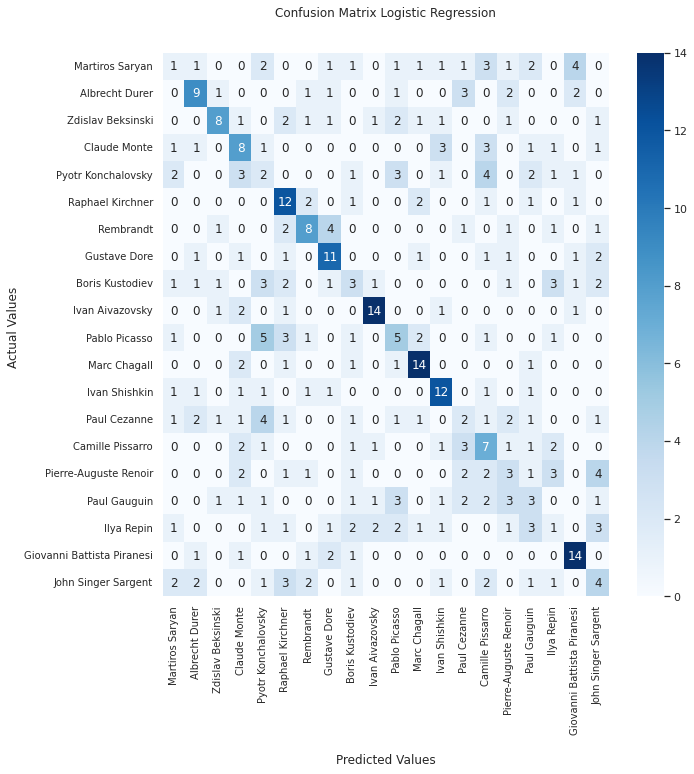

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

artists = ['Martiros Saryan','Albrecht Durer','Zdislav Beksinski','Claude Monte',
'Pyotr Konchalovsky','Raphael Kirchner','Rembrandt','Gustave Dore','Boris Kustodiev',
'Ivan Aivazovsky','Pablo Picasso','Marc Chagall','Ivan Shishkin','Paul Cezanne',
'Camille Pissarro','Pierre-Auguste Renoir','Paul Gauguin','Ilya Repin','Giovanni Battista Piranesi',
'John Singer Sargent']

cm = confusion_matrix(test_labels, preds)
sns.set(rc = {'figure.figsize':(10,10)})
ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix Logistic Regression\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(artists)
ax.yaxis.set_ticklabels(artists)

ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 10)
ax.set_xticklabels(ax.get_yticklabels(), rotation = 90, fontsize = 10)

# x axis on top
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')

## Display the visualization of the Confusion Matrix.
plt.show()

### AUC - ROC Curve

In [12]:
# Binarize the output
train_labels = label_binarize(train_labels, classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
test_labels = label_binarize(test_labels, classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

n_classes = 20
# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    LogisticRegression(penalty='l2',C=10)
)
y_score = classifier.fit(train, train_labels).decision_function(test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

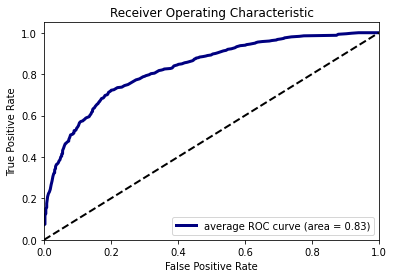

In [24]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
# plt.plot(
#     fpr["micro"],
#     tpr["micro"],
#     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
#     color="deeppink",
#     linestyle=":",
#     linewidth=4,
# )

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    # linestyle=":",
    linewidth=3,
)

# colors = cycle(["aqua", "darkorange", "cornflowerblue","tomato"])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(
#         fpr[i],
#         tpr[i],
#         color=color,
#         lw=lw,
#         label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
#     )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()